In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import numpy as np
import os

In [3]:
def merge_datasets(datasets):
    # Start by merging orders with customers
    merged = pd.merge(datasets['olist_orders_dataset'], datasets['olist_customers_dataset'], on='customer_id', how='left')

    # Add other datasets with the correct merge keys
    merge_keys = {
        'order_items': 'order_id',
        'order_payments': 'order_id',
        'order_reviews': 'order_id',
        'sellers': 'seller_id',
        'products': 'product_id',
        'product_category_name_translation': 'product_category_name'  # Make sure this dataset is loaded correctly
    }

    for name, key in merge_keys.items():
        if name in datasets:
            merged = pd.merge(merged, datasets[name], on=key, how='left')

    return merged

# Load individual datasets
olist_customers_df = pd.read_csv('olist_customers_dataset.csv')
order_items_df = pd.read_csv('olist_order_items_dataset.csv')
order_payments_df = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('olist_order_reviews_dataset.csv')
olist_orders_df = pd.read_csv('olist_orders_dataset.csv')
sellers_df = pd.read_csv('olist_sellers_dataset.csv')
products_df = pd.read_csv('olist_products_dataset.csv')
product_category_name_translation_df = pd.read_csv('product_category_name_translation.csv')

# Define the datasets dictionary
datasets = {
    'olist_customers_dataset': olist_customers_df,
    'order_items': order_items_df,
    'order_payments': order_payments_df,
    'order_reviews': order_reviews_df,
    'olist_orders_dataset': olist_orders_df,
    'sellers': sellers_df,
    'products': products_df,
    'product_category_name_translation': product_category_name_translation_df
}

# Now, you can call the merge_datasets function with the loaded datasets
merged_df = merge_datasets(datasets)


In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  object 
 1   customer_id                    119143 non-null  object 
 2   order_status                   119143 non-null  object 
 3   order_purchase_timestamp       119143 non-null  object 
 4   order_approved_at              118966 non-null  object 
 5   order_delivered_carrier_date   117057 non-null  object 
 6   order_delivered_customer_date  115722 non-null  object 
 7   order_estimated_delivery_date  119143 non-null  object 
 8   customer_unique_id             119143 non-null  object 
 9   customer_zip_code_prefix       119143 non-null  int64  
 10  customer_city                  119143 non-null  object 
 11  customer_state                 119143 non-null  object 
 12  order_item_id                 

In [5]:
# check for duplicates
merged_df.duplicated().sum()

0

In [6]:
# check for missing values by percentage in each column
merged_df.isnull().sum() / len(merged_df) * 100

order_id                          0.000000
customer_id                       0.000000
order_status                      0.000000
order_purchase_timestamp          0.000000
order_approved_at                 0.148561
order_delivered_carrier_date      1.750837
order_delivered_customer_date     2.871339
order_estimated_delivery_date     0.000000
customer_unique_id                0.000000
customer_zip_code_prefix          0.000000
customer_city                     0.000000
customer_state                    0.000000
order_item_id                     0.699160
product_id                        0.699160
seller_id                         0.699160
shipping_limit_date               0.699160
price                             0.699160
freight_value                     0.699160
payment_sequential                0.002518
payment_type                      0.002518
payment_installments              0.002518
payment_value                     0.002518
review_id                         0.836810
review_scor

In [7]:
# drop missing values column with more than 50% missing values
merged_df = merged_df.dropna(thresh=len(merged_df) * 0.5, axis=1)

# drop rows with missing values
merged_df = merged_df.dropna()

In [8]:
# check for missing values by percentage in each column
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113193 entries, 0 to 119142
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113193 non-null  object 
 1   customer_id                    113193 non-null  object 
 2   order_status                   113193 non-null  object 
 3   order_purchase_timestamp       113193 non-null  object 
 4   order_approved_at              113193 non-null  object 
 5   order_delivered_carrier_date   113193 non-null  object 
 6   order_delivered_customer_date  113193 non-null  object 
 7   order_estimated_delivery_date  113193 non-null  object 
 8   customer_unique_id             113193 non-null  object 
 9   customer_zip_code_prefix       113193 non-null  int64  
 10  customer_city                  113193 non-null  object 
 11  customer_state                 113193 non-null  object 
 12  order_item_id                  1131

In [9]:
# Clean and preprocess data
def preprocess_data(df):
    # Drop columns with more than 50% missing values
    df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)
    
    # Convert datetime columns
    datetime_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                    'order_delivered_customer_date', 'order_estimated_delivery_date', 
                    'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Calculate new features
    df['time_to_delivery'] = (df['order_delivered_customer_date'] - df['order_approved_at']).dt.days
    df['order_processing_time'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.days
    df['estimated_vs_actual_shipping'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
    df['product_volume_m3'] = (df['product_length_cm'] * df['product_width_cm'] * df['product_height_cm']) / 1000000
    df['satisfaction'] = (df['review_score'] >= 4).astype(int)
    df['order_value'] = df['price'] + df['freight_value']

    # create late delivery flag
    df['late_delivery'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)


    # Drop rows with missing values
    df.dropna(inplace=True)

    # create seasonal features from order_purchase_timestamp
    df['order_month'] = df['order_purchase_timestamp'].dt.month
    df['order_day'] = df['order_purchase_timestamp'].dt.dayofweek
    df['order_hour'] = df['order_purchase_timestamp'].dt.hour

    return df

merged_df = preprocess_data(merged_df)

In [10]:
# drop unnecessary columns
merged_df.drop(['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'review_score', 'seller_zip_code_prefix']
               , axis=1, inplace=True) 

In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113193 entries, 0 to 119142
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113193 non-null  object        
 1   customer_id                    113193 non-null  object        
 2   order_status                   113193 non-null  object        
 3   order_purchase_timestamp       113193 non-null  datetime64[ns]
 4   order_approved_at              113193 non-null  datetime64[ns]
 5   order_delivered_carrier_date   113193 non-null  datetime64[ns]
 6   order_delivered_customer_date  113193 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113193 non-null  datetime64[ns]
 8   customer_unique_id             113193 non-null  object        
 9   customer_zip_code_prefix       113193 non-null  int64         
 10  customer_city                  113193 non-null  object        
 11  custo

In [12]:
# check summary statistics
merged_df.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,order_item_id,shipping_limit_date,price,freight_value,...,time_to_delivery,order_processing_time,estimated_vs_actual_shipping,product_volume_m3,satisfaction,order_value,late_delivery,order_month,order_day,order_hour
count,113193,113193,113193,113193,113193,113193.000000,113193.000000,113193,113193.000000,113193.000000,...,113193.00000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000
mean,2018-01-01 07:46:22.707817472,2018-01-01 18:12:25.359050496,2018-01-04 14:19:54.360985088,2018-01-13 18:22:26.739418624,2018-01-25 03:50:01.955951616,35085.687437,1.195065,2018-01-07 22:21:08.998047488,119.846650,20.002595,...,11.51899,0.269142,11.091092,0.015306,0.768210,139.849246,0.076984,6.037432,2.746928,14.764614
min,2016-10-03 09:44:50,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-27 00:00:00,1003.000000,1.000000,2016-10-08 10:34:01,0.850000,0.000000,...,-7.00000,0.000000,-189.000000,0.000168,0.000000,6.080000,0.000000,1.000000,0.000000,0.000000
25%,2017-09-13 14:12:25,2017-09-13 22:05:44,2017-09-15 20:07:55,2017-09-25 18:34:40,2017-10-04 00:00:00,11310.000000,1.000000,2017-09-20 13:24:55,39.900000,13.080000,...,6.00000,0.000000,6.000000,0.002856,1.000000,55.260000,0.000000,3.000000,1.000000,11.000000
50%,2018-01-20 09:22:45,2018-01-20 16:00:33,2018-01-24 00:23:35,2018-02-02 02:15:19,2018-02-16 00:00:00,24315.000000,1.000000,2018-01-26 14:14:20,74.900000,16.320000,...,9.00000,0.000000,12.000000,0.006612,1.000000,91.780000,0.000000,6.000000,3.000000,15.000000
75%,2018-05-05 13:57:15,2018-05-05 19:50:47,2018-05-08 14:07:00,2018-05-15 20:02:55,2018-05-28 00:00:00,58865.000000,1.000000,2018-05-10 19:15:24,132.980000,21.190000,...,15.00000,0.000000,16.000000,0.018468,1.000000,157.300000,0.000000,8.000000,4.000000,19.000000
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,99980.000000,21.000000,2020-04-09 22:35:08,6735.000000,409.680000,...,208.00000,30.000000,146.000000,0.296208,1.000000,6929.310000,1.000000,12.000000,6.000000,23.000000
std,NaN,NaN,NaN,NaN,NaN,29867.822574,0.687526,NaN,181.079901,15.711728,...,9.32641,0.747635,10.090406,0.023409,0.421977,188.111745,0.266567,3.221918,1.961298,5.324879


In [13]:
# Check the distribution of the CSAT percentage
merged_df['satisfaction'].value_counts() / len(merged_df) * 100

satisfaction
1    76.821005
0    23.178995
Name: count, dtype: float64

In [14]:
# Identifying top 10 features with highest correlation with 'satisfaction'
# Select only the numeric columns for correlation calculation
numeric_cols = merged_df.select_dtypes(include=[np.number])

# Compute the correlation matrix for numeric columns only
corr_matrix = numeric_cols.corr()

# Print the top 10 features correaltion score
print(corr_matrix['satisfaction'].sort_values(ascending=False)[1:-1])

estimated_vs_actual_shipping    0.200293
order_month                     0.027864
order_hour                      0.009535
price                           0.008271
payment_sequential              0.007372
order_value                     0.005543
product_width_cm               -0.012533
order_day                      -0.015242
product_length_cm              -0.017906
order_processing_time          -0.018413
product_height_cm              -0.020917
customer_zip_code_prefix       -0.022217
product_volume_m3              -0.022307
product_weight_g               -0.023465
freight_value                  -0.028962
payment_installments           -0.042748
payment_value                  -0.068124
order_item_id                  -0.121016
time_to_delivery               -0.267583
Name: satisfaction, dtype: float64


In [15]:
# Set the correlation threshold
threshold = 0.05

# Get the features with correlation greater than 7% or less than -7% with 'satisfaction'
high_corr_features = corr_matrix.index[(corr_matrix['satisfaction'].abs() > threshold) & (corr_matrix.index != 'satisfaction')].tolist()

# Print the highly correlated features
print(high_corr_features)

['order_item_id', 'payment_value', 'time_to_delivery', 'estimated_vs_actual_shipping', 'late_delivery']


In [16]:
# check data types for top features
merged_df[high_corr_features].dtypes

order_item_id                   float64
payment_value                   float64
time_to_delivery                  int64
estimated_vs_actual_shipping      int64
late_delivery                     int32
dtype: object

In [17]:
top_4_features = ['payment_value', 'time_to_delivery', 'estimated_vs_actual_shipping', 'late_delivery']

In [18]:
top_6_features = ['estimated_vs_actual_shipping', 'order_month', 'order_hour', 'price', 'payment_sequential', 'order_value', 'payment_installments']
X = merged_df[top_4_features]
y = merged_df['satisfaction']

In [19]:
X

,payment_value,time_to_delivery,estimated_vs_actual_shipping,late_delivery
0,18.12,8,7,0
1,2.00,8,7,0
2,18.59,8,7,0
3,141.46,12,5,0
4,179.12,9,17,0
...,...,...,...,...
119138,195.00,22,1,0
119139,271.01,24,5,0
119140,441.16,17,20,0
119141,441.16,17,20,0


In [20]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pd.DataFrame(X_train,columns=X.columns).head()

,payment_value,time_to_delivery,estimated_vs_actual_shipping,late_delivery
73387,36.10,22,6,0
75103,52.57,3,12,0
64549,116.74,10,9,0
84018,58.62,4,9,0
110882,1989.75,15,7,0


In [21]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=50),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4)
}

In [22]:
# Function to fit models, make predictions, and evaluate them
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Plotting confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    print(f"{model_name} Classification Report:")
    print(class_report)

In [29]:
X


,payment_value,time_to_delivery,estimated_vs_actual_shipping,late_delivery
0,18.12,8,7,0
1,2.00,8,7,0
2,18.59,8,7,0
3,141.46,12,5,0
4,179.12,9,17,0
...,...,...,...,...
119138,195.00,22,1,0
119139,271.01,24,5,0
119140,441.16,17,20,0
119141,441.16,17,20,0


Evaluating Logistic Regression


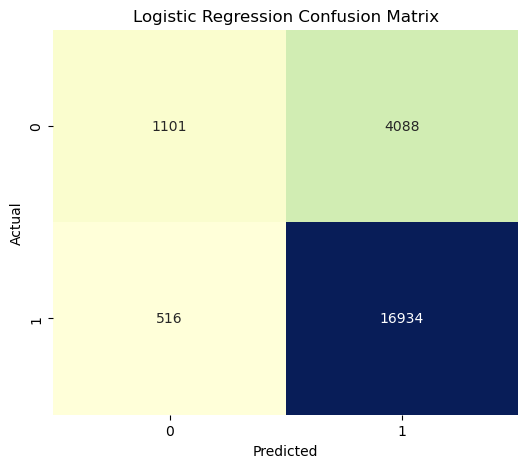

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.21      0.32      5189
           1       0.81      0.97      0.88     17450

    accuracy                           0.80     22639
   macro avg       0.74      0.59      0.60     22639
weighted avg       0.78      0.80      0.75     22639

Evaluating Decision Tree


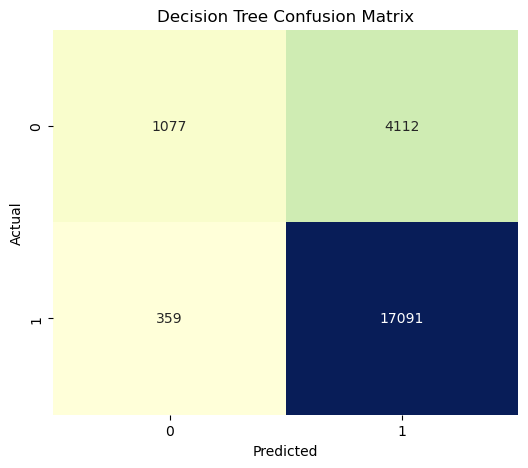

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.21      0.33      5189
           1       0.81      0.98      0.88     17450

    accuracy                           0.80     22639
   macro avg       0.78      0.59      0.60     22639
weighted avg       0.79      0.80      0.76     22639

Evaluating Random Forest


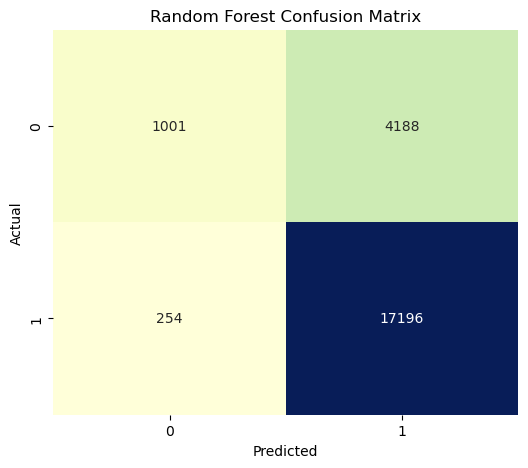

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.19      0.31      5189
           1       0.80      0.99      0.89     17450

    accuracy                           0.80     22639
   macro avg       0.80      0.59      0.60     22639
weighted avg       0.80      0.80      0.75     22639



In [23]:
# Evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}")
    evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, model_name)

In [24]:
# Initialize the XGBoost Classifier
RF_model = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Fewer trees to keep the model simpler
    'max_depth': [3, 4, 5],          # Shallow trees to prevent overfitting
    'max_features': ['sqrt'],        # Use 'sqrt' as the only option for max_features
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RF_model,
    param_grid=param_grid,
    scoring='accuracy',  # or another scoring metric
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predictions
train_preds = best_model.predict(X_train_scaled)
test_preds = best_model.predict(X_test_scaled)


Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [25]:
# Function to plot confusion matrix
def plot_confusion_matrix(true_values, predictions, set_name):
    matrix = confusion_matrix(true_values, predictions)
    plt.figure(figsize=(6,5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='twilight', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{set_name} Confusion Matrix')
    plt.show()

In [26]:
# Function to print classification report
def print_classification_report(true_values, predictions, set_name):
    report = classification_report(true_values, predictions)
    print(f"{set_name} Classification Report:")
    print(report)

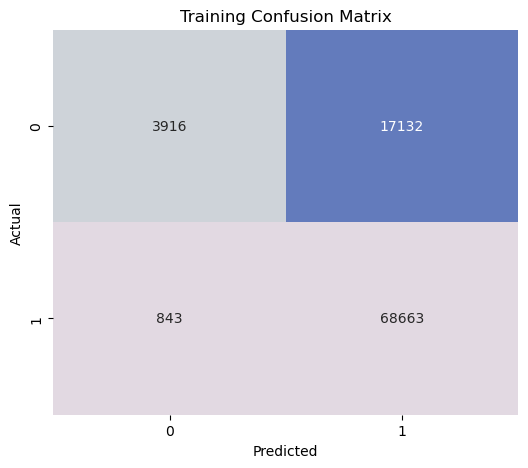

Training Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.19      0.30     21048
           1       0.80      0.99      0.88     69506

    accuracy                           0.80     90554
   macro avg       0.81      0.59      0.59     90554
weighted avg       0.81      0.80      0.75     90554



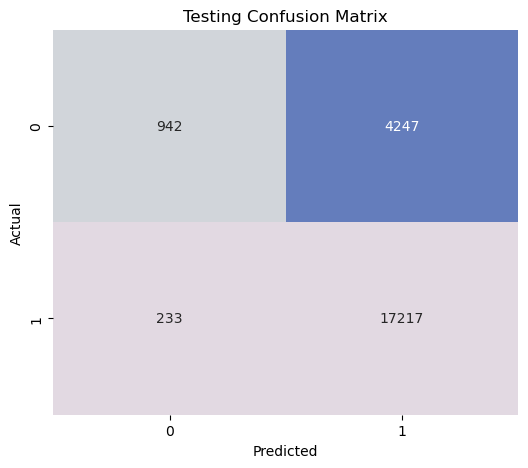

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.18      0.30      5189
           1       0.80      0.99      0.88     17450

    accuracy                           0.80     22639
   macro avg       0.80      0.58      0.59     22639
weighted avg       0.80      0.80      0.75     22639

Best Parameters: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.8008812396441575


In [27]:
# Visualize and print reports for both sets
plot_confusion_matrix(y_train, train_preds, "Training")
print_classification_report(y_train, train_preds, "Training")

plot_confusion_matrix(y_test, test_preds, "Testing")
print_classification_report(y_test, test_preds, "Testing")

# Print best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [28]:
# step 11 To write the pickle files for the future IV prediction
import pickle
pickle.dump(scaler,open('scaler.pkl', 'wb'))
pickle.dump(best_model,open('best_model.pkl', 'wb'))